## 深度学习图像去噪－－基于空洞卷积

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import tensorflow as tf
from keras.layers import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras import Model
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio
import glob
from time import time

In [3]:
## 定义辅助函数    图像转化为图像块
def image2cols(image,patch_size,stride):
    import numpy as np
    imhigh,imwidth = image.shape
    range_y = np.arange(0,imhigh - patch_size,stride)
    range_x = np.arange(0,imwidth - patch_size,stride)
    if range_y[-1] != imhigh - patch_size:
        range_y = np.append(range_y,imhigh - patch_size)
    if range_x[-1] != imwidth - patch_size:
        range_x = np.append(range_x,imwidth - patch_size)
    sz = len(range_y) * len(range_x)
    res = np.zeros((sz,patch_size,patch_size))
    index = 0
    for y in range_y:
        for x in range_x:
            patch = image[y:y+patch_size,x:x+patch_size]
            res[index,:,:] = patch
            index = index + 1
    return res          

## 定义函数  图像转化为图像块的逆变换
def col2image(coldata,imsize,stride):
    patch_size = coldata.shape[1]
    res = np.zeros((imsize[0],imsize[1]))
    w = np.zeros(((imsize[0],imsize[1])))
    range_y = np.arange(0,imsize[0] - patch_size,stride)
    range_x = np.arange(0,imsize[1] - patch_size,stride)
    if range_y[-1] != imsize[0] - patch_size:
        range_y = np.append(range_y,imsize[0] - patch_size)
    if range_x[-1] != imsize[1] - patch_size:
        range_x = np.append(range_x,imsize[1] - patch_size)
    index = 0
    for y in range_y:
        for x in range_x:
            res[y:y+patch_size,x:x+patch_size] = res[y:y+patch_size,x:x+patch_size] + coldata[index]
            w[y:y+patch_size,x:x+patch_size] = w[y:y+patch_size,x:x+patch_size] + 1
            index = index + 1
    
    return res / w

In [4]:
## 图像数据准备
## 读取训练图像图像
filelist = glob.glob("data/Train400/*.png")
traindata = np.array([imread(fname) for fname in filelist])
traindata = traindata / 255.0
print("图像数据集:",traindata.shape)

图像数据集: (400, 180, 180)


In [5]:
## 数据集添加高斯噪声
def gaussian_noise(x_train,sigma,seed=1243):  
    """sigma:噪声标准差"""
    sigma2 = sigma**2 / (255**2)  ## 噪声方差
    x_train_noisy = np.zeros_like(x_train)
    for ii in range(x_train.shape[0]):
        image = x_train[ii]
        noise_im = random_noise(image,mode="gaussian", var=sigma2,seed=seed,clip=True)
        x_train_noisy[ii] = noise_im
    return x_train_noisy
x_train_noisy = gaussian_noise(traindata,30,seed=1243)
print("x_train_noisy",x_train_noisy.min(),"~",x_train_noisy.max())

x_train_noisy 0.0 ~ 1.0


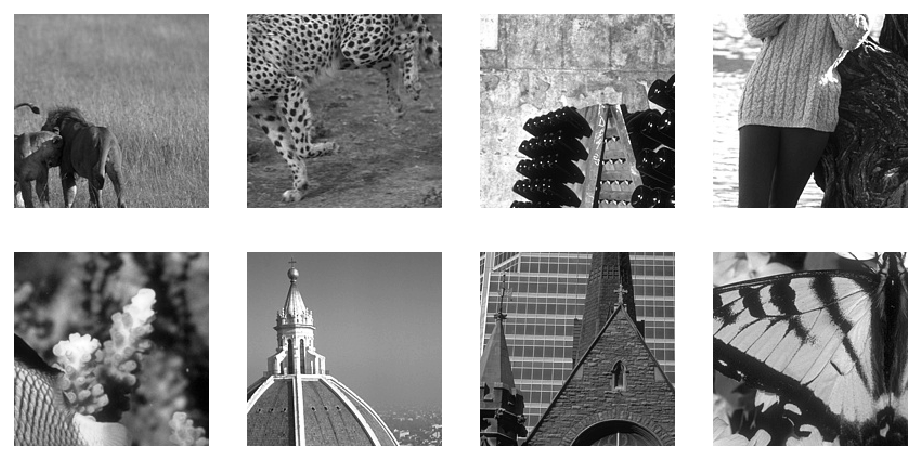

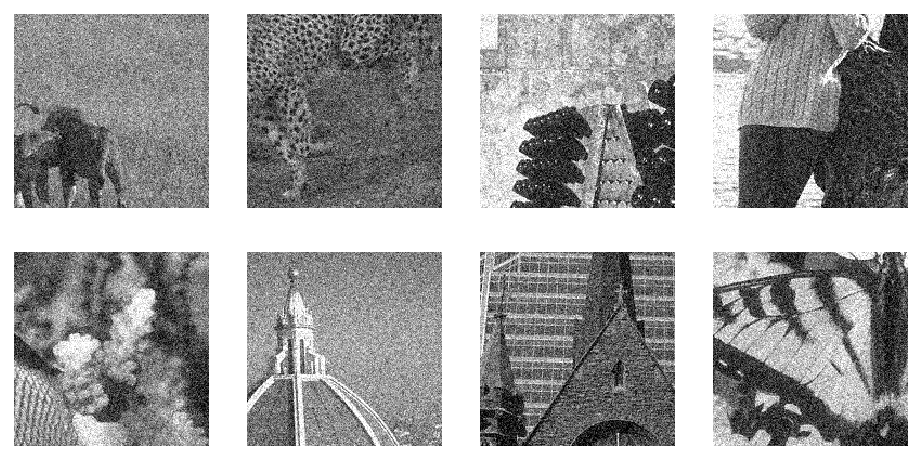

In [6]:
## 查看其中的几幅图像
index = np.arange(5,400,20)
plt.figure(figsize=(8,4))
for i in range(0,8):
    plt.subplot(2,4, i+1)
    plt.imshow(traindata[index[i],:,:])
    plt.gray()
    plt.axis("off")
plt.show()

## 查看添加噪声后其中的几幅图像
plt.figure(figsize=(8,4))
for i in range(0,8):
    plt.subplot(2,4, i+1)
    plt.imshow(x_train_noisy[index[i],:,:])
    plt.gray()
    plt.axis("off")
plt.show()


In [7]:
## 将不带噪声数据和带噪声数据进一步切分位图像块，图像块大小为50*50，切割步长为40
def trainim2col(traindata,patch_size = 50,stride = 10):
    imnum = traindata.shape[0]
    resdata  = image2cols(traindata[0],patch_size = patch_size,stride = stride)
    for ii in np.arange(1,imnum):
        resdataii = image2cols(traindata[ii],patch_size = patch_size,stride = stride)
        resdata = np.concatenate((resdata,resdataii),axis = 0)
    return resdata

In [8]:
t0 = time()
print("图像数据转化为图像块...")
traindata_patch = trainim2col(traindata,patch_size = 50,stride = 40)
print(traindata_patch.shape)
train_noisy_patch = trainim2col(x_train_noisy,patch_size = 50,stride = 40)
print(train_noisy_patch.shape)
print("use %.2fs" %(time()-t0))

图像数据转化为图像块...
(10000, 50, 50)
(10000, 50, 50)
use 41.47s


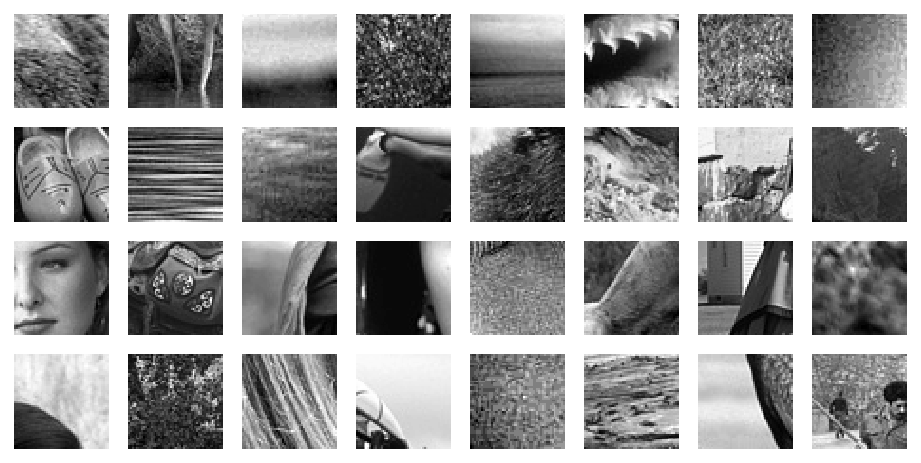

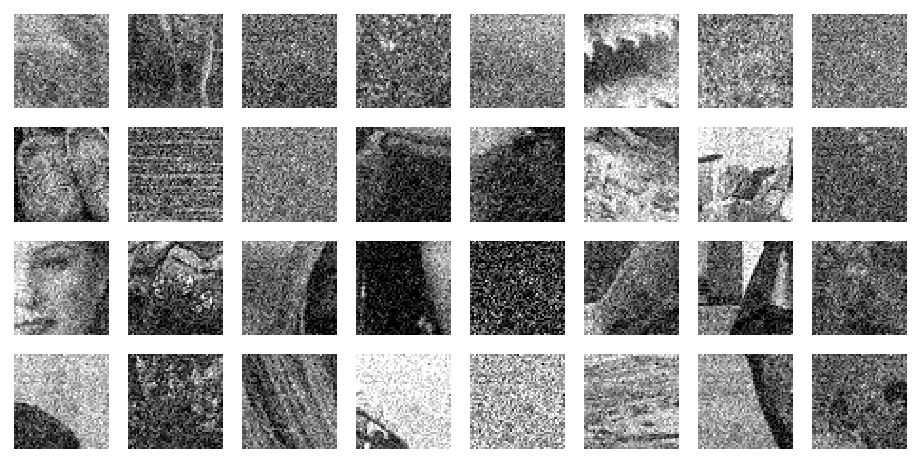

In [9]:
## 查看其中的几幅图像
index = np.arange(5,4000,100)
plt.figure(figsize=(8,4))
for i in range(0,32):
    plt.subplot(4,8, i+1)
    plt.imshow(traindata_patch[index[i],:,:])
    plt.gray()
    plt.axis("off")
plt.show()
plt.figure(figsize=(8,4))
for i in range(0,32):
    plt.subplot(4,8, i+1)
    plt.imshow(train_noisy_patch[index[i],:,:])
    plt.gray()
    plt.axis("off")
plt.show()

In [10]:
## 3为数据转化为4维数据
imnum,imwidth,imhigh = traindata_patch.shape
traindata_patch = np.reshape(traindata_patch,(imnum,imwidth,imhigh,1))
train_noisy_patch = np.reshape(train_noisy_patch,(imnum,imwidth,imhigh,1))
print(train_noisy_patch.shape)

(10000, 50, 50, 1)


### 建立深度卷积模型

In [11]:
from keras.layers import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras import Sequential
from keras.models import load_model

In [12]:
#将数据集切分位训练集和验证集
train_size = int(traindata_patch.shape[0]*0.8)
train_clean = traindata_patch[0:train_size]
train_noisy = train_noisy_patch[0:train_size]
test_clean = traindata_patch[train_size:]
test_noisy = train_noisy_patch[train_size:]
print(train_clean.shape)
print(test_clean.shape)

(8000, 50, 50, 1)
(2000, 50, 50, 1)


In [13]:
## 建立模型
model = Sequential()  ## 初始化模型
## 因为每张图像识180*180的，所以inputs=(180,180)，卷积核大小为3*3，需要输出64个feature map
model.add(Conv2D(64,(3,3),activation="relu",
                 padding="same",dilation_rate=(1, 1),
                 input_shape=(50,50,1)))
model.add(BatchNormalization(name="BN_1"))
## 第二层卷积操作后输出64个feature map，卷积核大小3*3
model.add(Conv2D(64,(3,3),activation="relu",
                 padding="same",dilation_rate=(2, 2)))
model.add(BatchNormalization(name="BN_2"))
## 第3层卷积操作后输出64个feature map，卷积核大小3*3
model.add(Conv2D(64,(3,3),activation="relu",
                 padding="same",dilation_rate=(3, 3)))
model.add(BatchNormalization(name="BN_3"))
## 第4层卷积操作后输出64个feature map，卷积核大小3*3
model.add(Conv2D(64,(3,3),activation="relu",
                 padding="same",dilation_rate=(4, 4)))
model.add(BatchNormalization(name="BN_4"))
## 第5层卷积操作后输出64个feature map，卷积核大小3*3
model.add(Conv2D(64,(3,3),activation="relu",
                 padding="same",dilation_rate=(3, 3)))
model.add(BatchNormalization(name="BN_5"))
## 第6层卷积操作后输出64个feature map，卷积核大小3*3
model.add(Conv2D(64,(3,3),activation="relu",
                 padding="same",dilation_rate=(2, 2)))
model.add(BatchNormalization(name="BN_6"))
## 第7层卷积操作后输出1个feature map，卷积核大小3*3
model.add(Conv2D(1,(3,3),activation="relu",
                 padding="same",dilation_rate=(1, 1)))
## 定义优化算法
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss = 'mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 64)        640       
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 50, 50, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 50, 50, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
BN_3 (BatchNormalization)    (None, 50, 50, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        3

In [ ]:
t0 = time()
print("模型正在训练...")
model_fit = model.fit(train_noisy, train_clean,
                      epochs=10,batch_size=64,
                      validation_data=(test_noisy, test_clean),verbose=1)
print("模型训练结束,use %.2fs" %(time()-t0))

模型正在训练...
Epoch 1/10
125/125 [==============================] - 301s 2s/step - loss: 0.1088 - val_loss: 0.0641
Epoch 2/10
 51/125 [===========>..................] - ETA: 2:53 - loss: 0.0222

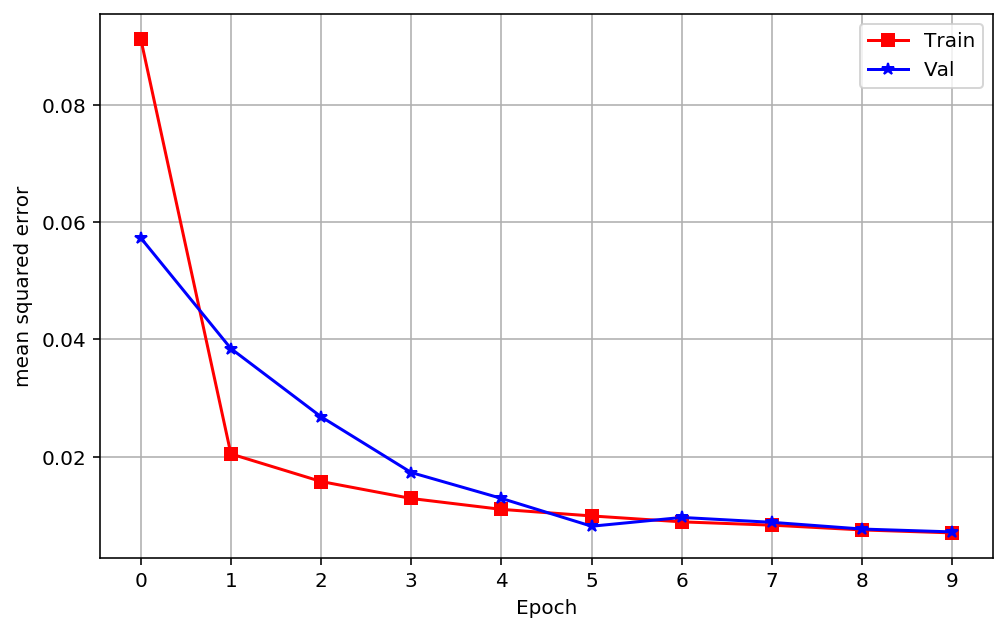

In [28]:
## 训练结果
model_fit.history
model_fit.epoch
plt.figure(figsize=(8,5))
plt.plot(model_fit.epoch,model_fit.history["loss"],"rs-",label = "Train")
plt.plot(model_fit.epoch,model_fit.history["val_loss"],"b*-",label = "Val")
plt.xticks(model_fit.epoch,model_fit.epoch)
plt.grid("on")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("mean squared error")
plt.show()

In [15]:

# 重新载入模型
model = load_model("data/convdenoise.h5")

In [16]:
## 拿新的图像对噪声进行测试
testim = imread("data/Test/08.png")
## 图像添加噪声
sigma2 = 30**2 / (255**2) 
noiseim = random_noise(testim,mode="gaussian", var=sigma2,seed=1234,clip=True)
## 对图像块进行去噪处理
## 转化为图像块
noiseimdata = image2cols(noiseim,50,40)
impatchnum,impatchwidth,impatchhigh = noiseimdata.shape
noiseimdata = np.reshape(noiseimdata,(impatchnum,impatchwidth,impatchhigh,1))
## 对图像块去噪
denoiseimdata = model.predict(noiseimdata)
denoiseimdata = np.reshape(denoiseimdata,(impatchnum,impatchwidth,impatchhigh))
## 图像块转化为去噪后图像
denoiseim = col2image(denoiseimdata,noiseim.shape,40)

In [17]:
## 计算去噪后的PSNR
print("加噪后的PSNR:",peak_signal_noise_ratio(testim / 255.0,noiseim),"dB")
print("去噪后的PSNR:",peak_signal_noise_ratio(testim / 255.0,denoiseim),"dB")

加噪后的PSNR: 18.6876845519533 dB
去噪后的PSNR: 24.939425971352023 dB


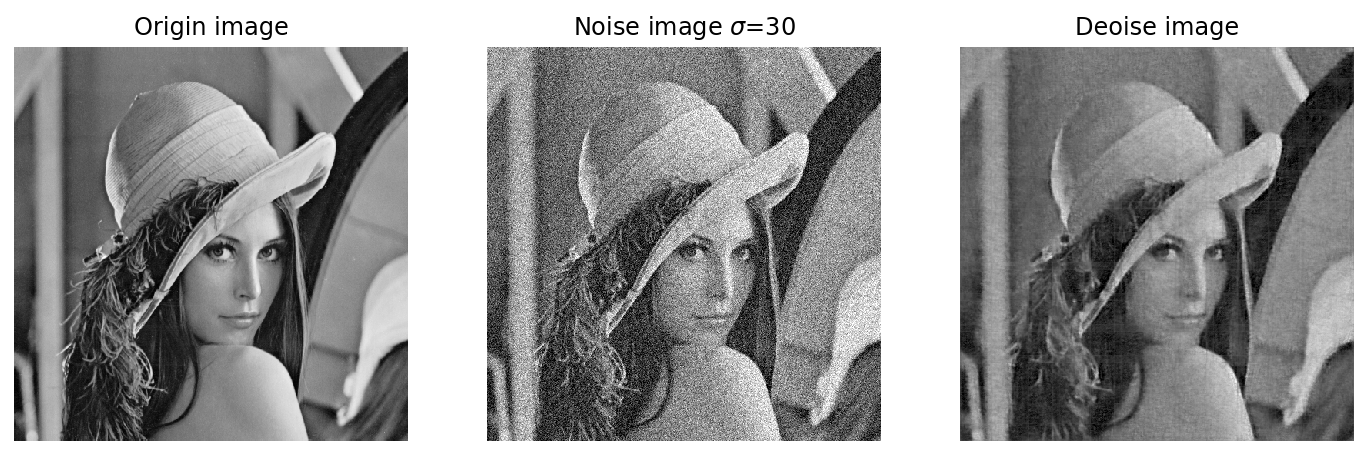

In [18]:
## 将图像可视化
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(testim,cmap=plt.cm.gray)
plt.axis("off")
plt.title("Origin image")
plt.subplot(1,3,2)
plt.imshow(noiseim,cmap=plt.cm.gray)
plt.axis("off")
plt.title("Noise image $\sigma$=30")
plt.subplot(1,3,3)
plt.imshow(denoiseim,cmap=plt.cm.gray)
plt.axis("off")
plt.title("Deoise image")
plt.show()
